## Install the package dependencies before running this notebook

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

#### Create a Torch.Dataset class for the training dataset

In [29]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        if split == 'train':
            data = (self.inputs[idx], self.outputs[idx])
        else:
            data = self.inputs[idx]
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'austin' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

#### Data Visualization

In [38]:
train_dt = {}
for city in cities:
    train_dt[city] = ArgoverseDataset(city=city, split="train")

In [39]:
test_dt = {}
for city in cities:
    test_dt[city] = ArgoverseDataset(city=city, split="test")

In [40]:
for city in train_dt:
    print(f"{city} train size: {len(train_dt[city])}")
    print(f"{city} test size: {len(test_dt[city])}")

austin train size: 43041
austin test size: 6325
miami train size: 55029
miami test size: 7971
pittsburgh train size: 43544
pittsburgh test size: 6361
dearborn train size: 24465
dearborn test size: 3671
washington-dc train size: 25744
washington-dc test size: 3829
palo-alto train size: 11993
palo-alto test size: 1686


##### Input and Output Positions

In [31]:
X_input = []
Y_input = []
X_output = []
Y_output = []
for city in train_dt:
    for input, output in train_dt[city]:
        for x,y in input:
            X_input.append(x)
            Y_input.append(y)
        for x,y in output:
            X_output.append(x)
            Y_output.append(y)

In [32]:
minX_input = np.floor(min(X_input))
maxX_input = np.ceil(max(X_input))
minY_input = np.floor(min(Y_input))
maxY_input = np.ceil(max(Y_input))

minX_output = np.floor(min(X_output))
maxX_output = np.ceil(max(X_output))
minY_output = np.floor(min(Y_output))
maxY_output = np.ceil(max(Y_output))

print(f'minimum (x, y) position: ({minX_input}, {minY_input})')
print(f'maximum (x, y) position: ({maxX_input}, {maxY_input})')
print(f'max X - min X: {maxX_input- minX_input}')
print(f'max Y - min Y: {maxY_input - minY_input}')

minimum (x, y) position: (-9223.0, -4536.0)
maximum (x, y) position: (13296.0, 7099.0)
max X - min X: 22519.0
max Y - min Y: 11635.0


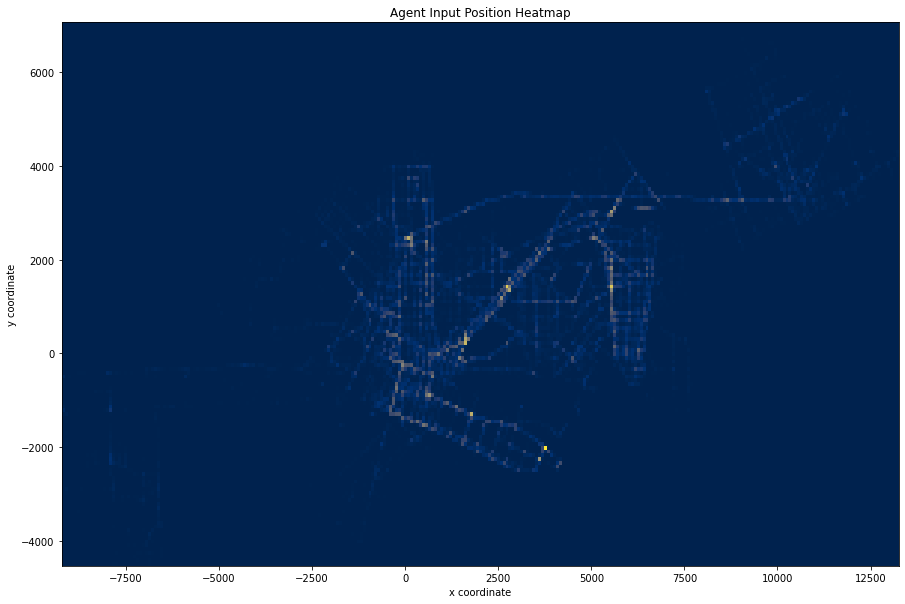

In [6]:
step_size = 80
plt.figure(figsize=(15,10))
plt.hist2d(X_input, Y_input, bins = (np.arange(minX_input, maxX_input, step_size), np.arange(minY_input, maxY_input, step_size)), cmap='cividis')
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.title("Agent Input Position Heatmap")
plt.show()

Text(0.5, 1.0, 'Agent Output Position Heatmap')

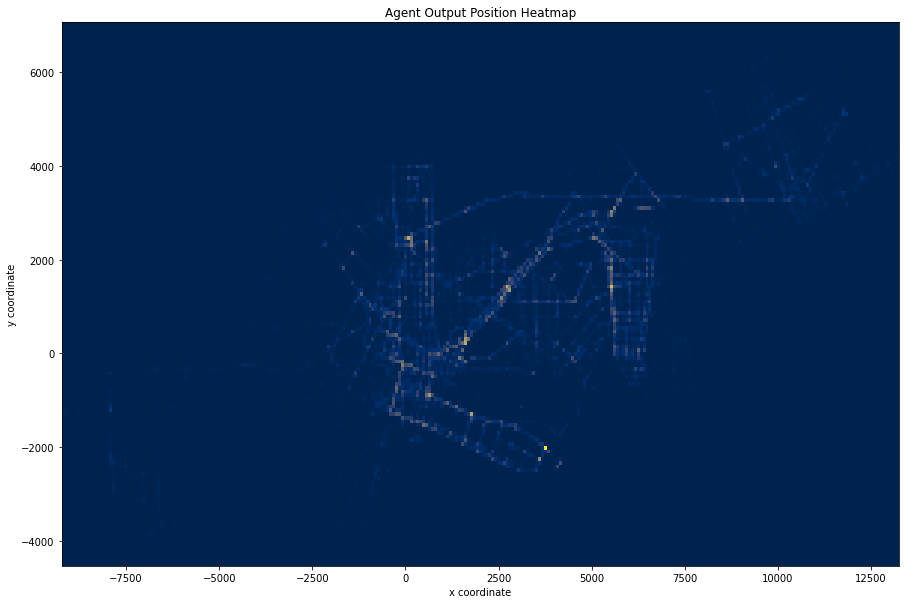

In [7]:
plt.figure(figsize=(15,10))
plt.hist2d(X_output,Y_output, bins = (np.arange(minX_output, maxX_output, step_size), np.arange(minY_input, maxY_input, step_size)), cmap='cividis')
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.title("Agent Output Position Heatmap")

##### Positions in Different Cities

In [33]:
def ProcessCityPositionData(city, step=200):
    X_pos = []
    Y_pos = []
    for input,output in ArgoverseDataset(city = city, split = split):
        for x,y in input:
            X_pos.append(x)
            Y_pos.append(y)
        for x,y in output:
            X_pos.append(x)
            Y_pos.append(y)
    minX = np.floor(min(X_pos))
    maxX = np.ceil(max(X_pos))
    minY = np.floor(min(Y_pos))
    maxY = np.ceil(max(Y_pos))
    N_bins = (np.arange(minX, maxX, step), np.arange(minY, maxY, step))
    
    return X_pos, Y_pos, N_bins

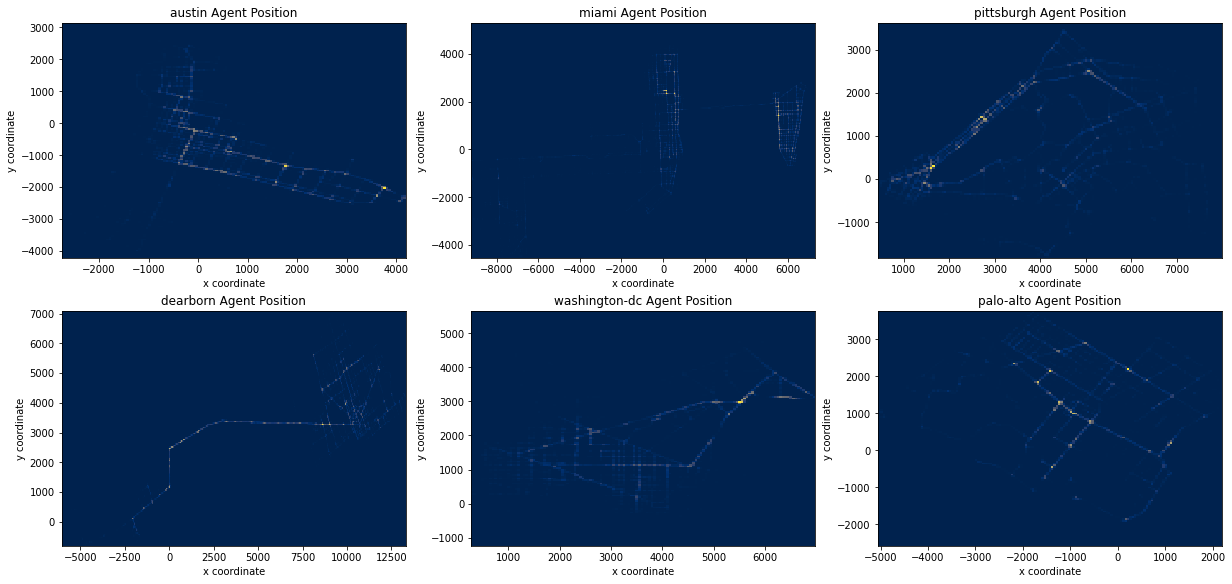

In [34]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(17,8), constrained_layout=True)
for id,ax in enumerate(axes.flat):
    X, Y, N_bins = ProcessCityPositionData(city=cities[id], step=50)
    ax.hist2d(X,Y,N_bins, cmap = 'cividis')
    ax.set_xlabel("x coordinate")
    ax.set_ylabel("y coordinate")
    ax.set_title(cities[id] + " Agent Position")

##### Speed Analysis

In [123]:
print(f"Number of entries in the Austin data set: {len(train_dt['austin'])}")
print(f"Number of time stamps in a data point: {len(train_dt['austin'][0][0]) + len(train_dt['austin'][0][1])}")

Number of entries in the Austin data set: 43041
Number of time stamps in a data point: 110


In [202]:
def ProcessCitySpeed(city, split=None):
    """
    train_dt[citiy_name][data_point][input/output][time point][X/Y]
    """
    X_pos = []
    Y_pos = []
    for input, output in train_dt[city]:
        if split == None:
            X_pos.append(np.concatenate((input[:, 0], output[:, 0]), axis=None))
            Y_pos.append(np.concatenate((input[:, 1], output[:, 1]), axis=None))
        if split == 'input':
            X_pos.append(input[:, 0])
            Y_pos.append(input[:, 1])
        if split == 'output':
            X_pos.append(output[:, 0])
            Y_pos.append(output[:, 1])
    
    X_pos = np.asarray(X_pos)
    Y_pos = np.asarray(Y_pos)
    
    dX_t = X_pos[:, 1:] -  X_pos[:, :-1]
    dY_t = Y_pos[:, 1:] -  Y_pos[:, :-1]
            
    speed = 10*((dX_t**2 + dY_t**2)**0.5)
    mean_speed = np.mean(speed, axis=0)
    sd_speed = np.std(speed, axis=0)
    return mean_speed, sd_speed

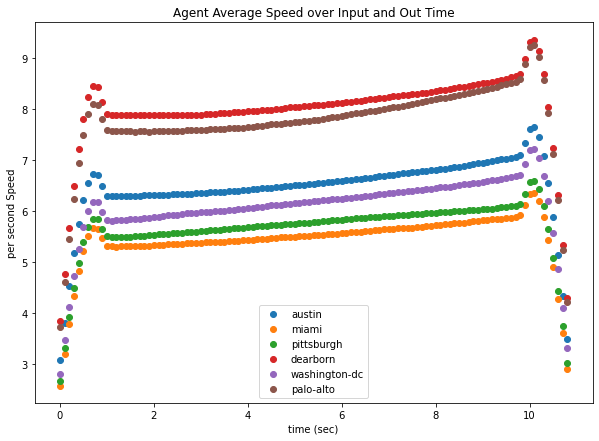

In [206]:
fig2= plt.figure(figsize=(10,7))
time = np.arange(0, 10.9, 0.1)
for c in cities:
    Y, _ = ProcessCitySpeed(c)
    plt.scatter(time, Y)
    
plt.xlabel("time (sec)")
plt.ylabel("per second speed")
plt.title("Agent Average Speed over Input and Out Time")
plt.legend(cities)

Clearly, we can see a difference across average speed in the middle of the sample

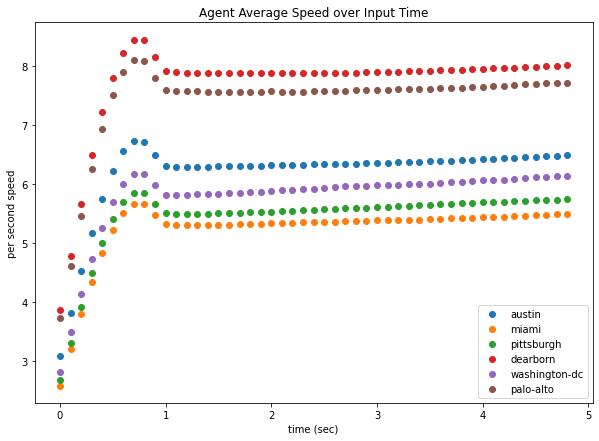

In [207]:
fig3= plt.figure(figsize=(10,7))
for c in cities:
    Y, _ = ProcessCitySpeed(c, 'input')
    plt.scatter(np.arange(0, 4.9, 0.1), Y)
    
plt.xlabel("time (sec)")
plt.ylabel("per second speed")
plt.title("Agent Average Speed over Input Time")
plt.legend(cities)

#### Create a DataLoader class for training

In [21]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

## Sample a batch of data and visualize 

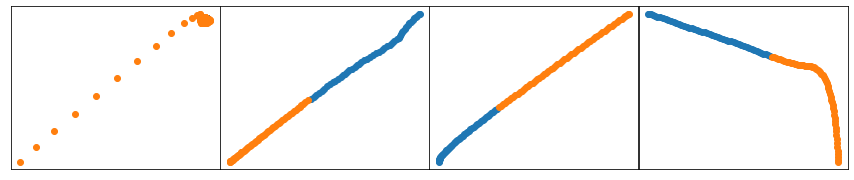

In [22]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    if i_batch > 0:
      break
    
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)